In [37]:
import pyvisa
import matplotlib
import numpy as np
import scipy

In [38]:
rm = pyvisa.ResourceManager()
print(rm.list_resources())
print(rm)

('GPIB0::25::INSTR', 'GPIB1::26::INSTR')
Resource Manager of Visa Library at C:\Windows\system32\visa32.dll


In [39]:
keithley = rm.open_resource('GPIB0::25::INSTR')
gatekeithley = rm.open_resource('GPIB1::26::INSTR')

In [40]:
print(keithley.query('*IDN?'))

KEITHLEY INSTRUMENTS INC.,MODEL 2400,1197267,C33   Mar 31 2015 09:32:39/A02  /K/J



Conductance: 4.8934577412353495e-11 Siemens


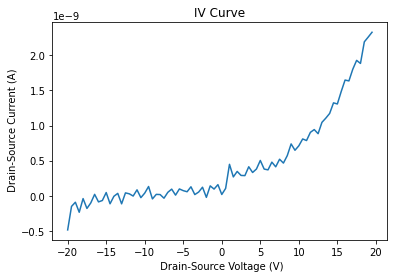

In [63]:
%run KeithleyIVSweep.py -20 20 0.5 test.txt

Conductance: 2.169776136053889e-09 Siemens


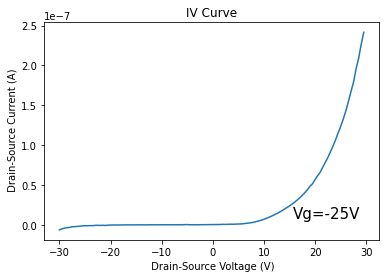

In [132]:
%run KeithleyIVSweepFixedGate.py -30 30 0.5 -25 Output_P2_3_m25.txt

Conductance: 1.5019532746146156e-07 Siemens


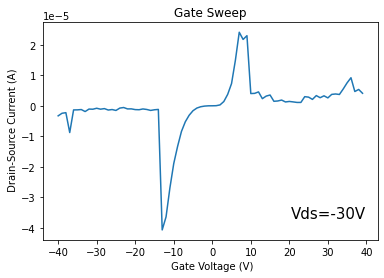

In [140]:
%run KeithleyGateSweepFixedDrain.py -40 40 1 -30 Transfer_P2_3_m30.txt